In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 256

In [3]:
file_name = 'wheat_40_var_avg_new.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 2
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(64512, 147, 1)
(16128, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Conv1D(filters=32, kernel_size=5))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1000)              1

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
from IPython.display import clear_output

for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))
    
#     clear_output(wait=True)


Epoch:  1
252/252 - 7s - loss: 1.2123 - accuracy: 0.4410 - 7s/epoch - 27ms/step
for training
2016/2016 [==============================] - 11s 6ms/step - loss: 1.1332 - accuracy: 0.5239
for testing
504/504 [==============================] - 3s 6ms/step - loss: 1.1348 - accuracy: 0.5182

Epoch:  2
252/252 - 6s - loss: 1.1042 - accuracy: 0.5303 - 6s/epoch - 23ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 1.0594 - accuracy: 0.5539
for testing
504/504 [==============================] - 2s 4ms/step - loss: 1.0602 - accuracy: 0.5510

Epoch:  3
252/252 - 5s - loss: 1.0053 - accuracy: 0.5687 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.9256 - accuracy: 0.6024
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.9262 - accuracy: 0.5996

Epoch:  4
252/252 - 5s - loss: 0.8987 - accuracy: 0.6113 - 5s/epoch - 22ms/step
for training
2016/2016 [==============================] - 8s

2016/2016 [==============================] - 8s 4ms/step - loss: 0.4104 - accuracy: 0.8300
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.4127 - accuracy: 0.8309

Epoch:  30
252/252 - 5s - loss: 0.4160 - accuracy: 0.8264 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.4080 - accuracy: 0.8289
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.4099 - accuracy: 0.8263

Epoch:  31
252/252 - 5s - loss: 0.4174 - accuracy: 0.8254 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.4363 - accuracy: 0.8158
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.4397 - accuracy: 0.8154

Epoch:  32
252/252 - 5s - loss: 0.4141 - accuracy: 0.8279 - 5s/epoch - 20ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.4148 - accuracy: 0.8265
for testing
504/504 [===========================

504/504 [==============================] - 1s 2ms/step - loss: 0.3082 - accuracy: 0.8751

Epoch:  58
252/252 - 4s - loss: 0.3163 - accuracy: 0.8724 - 4s/epoch - 15ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2999 - accuracy: 0.8779
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.3019 - accuracy: 0.8766

Epoch:  59
252/252 - 4s - loss: 0.3169 - accuracy: 0.8695 - 4s/epoch - 15ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.3106 - accuracy: 0.8727
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.3116 - accuracy: 0.8712

Epoch:  60
252/252 - 4s - loss: 0.3113 - accuracy: 0.8736 - 4s/epoch - 15ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2820 - accuracy: 0.8868
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2847 - accuracy: 0.8875

Epoch:  61
252/252 - 4s - loss: 0.3001 - accuracy

for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2452 - accuracy: 0.9007
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2487 - accuracy: 0.8981

Epoch:  87
252/252 - 4s - loss: 0.2512 - accuracy: 0.8990 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2561 - accuracy: 0.8945
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2589 - accuracy: 0.8943

Epoch:  88
252/252 - 4s - loss: 0.2445 - accuracy: 0.9019 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2958 - accuracy: 0.8786
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2992 - accuracy: 0.8782

Epoch:  89
252/252 - 4s - loss: 0.2441 - accuracy: 0.9024 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2163 - accuracy: 0.9150
for testing
504/504 [==============

504/504 [==============================] - 1s 2ms/step - loss: 0.2190 - accuracy: 0.9114

Epoch:  115
252/252 - 4s - loss: 0.2079 - accuracy: 0.9176 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1833 - accuracy: 0.9302
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1890 - accuracy: 0.9278

Epoch:  116
252/252 - 4s - loss: 0.2091 - accuracy: 0.9167 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1861 - accuracy: 0.9289
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1878 - accuracy: 0.9271

Epoch:  117
252/252 - 4s - loss: 0.2043 - accuracy: 0.9188 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1970 - accuracy: 0.9224
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2005 - accuracy: 0.9221

Epoch:  118
252/252 - 4s - loss: 0.2072 - accu

for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1652 - accuracy: 0.9365
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1708 - accuracy: 0.9347

Epoch:  144
252/252 - 4s - loss: 0.1816 - accuracy: 0.9292 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1650 - accuracy: 0.9360
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1712 - accuracy: 0.9350

Epoch:  145
252/252 - 4s - loss: 0.1804 - accuracy: 0.9306 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1782 - accuracy: 0.9317
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1852 - accuracy: 0.9297

Epoch:  146
252/252 - 4s - loss: 0.1782 - accuracy: 0.9309 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1756 - accuracy: 0.9322
for testing
504/504 [===========

504/504 [==============================] - 1s 3ms/step - loss: 0.1893 - accuracy: 0.9260

Epoch:  172
252/252 - 4s - loss: 0.1582 - accuracy: 0.9385 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1422 - accuracy: 0.9481
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1476 - accuracy: 0.9438

Epoch:  173
252/252 - 4s - loss: 0.1590 - accuracy: 0.9392 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 2ms/step - loss: 0.1672 - accuracy: 0.9321
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.1729 - accuracy: 0.9316

Epoch:  174
252/252 - 4s - loss: 0.1663 - accuracy: 0.9350 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.2280 - accuracy: 0.9111
for testing
504/504 [==============================] - 1s 2ms/step - loss: 0.2369 - accuracy: 0.9090

Epoch:  175
252/252 - 4s - loss: 0.1648 - accu

for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1549 - accuracy: 0.9383
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1611 - accuracy: 0.9358

Epoch:  201
252/252 - 4s - loss: 0.1526 - accuracy: 0.9407 - 4s/epoch - 16ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1744 - accuracy: 0.9284
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1788 - accuracy: 0.9291

Epoch:  202
252/252 - 4s - loss: 0.1502 - accuracy: 0.9430 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1494 - accuracy: 0.9414
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1571 - accuracy: 0.9397

Epoch:  203
252/252 - 4s - loss: 0.1411 - accuracy: 0.9454 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.1303 - accuracy: 0.9496
for testing
504/504 [===========

504/504 [==============================] - 1s 3ms/step - loss: 0.1383 - accuracy: 0.9469

Epoch:  229
252/252 - 4s - loss: 0.1330 - accuracy: 0.9489 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1324 - accuracy: 0.9497
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1388 - accuracy: 0.9469

Epoch:  230
252/252 - 4s - loss: 0.1376 - accuracy: 0.9467 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1230 - accuracy: 0.9538
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1307 - accuracy: 0.9497

Epoch:  231
252/252 - 4s - loss: 0.1275 - accuracy: 0.9523 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1590 - accuracy: 0.9345
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.9369

Epoch:  232
252/252 - 4s - loss: 0.1323 - accu

for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1373 - accuracy: 0.9460
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1479 - accuracy: 0.9433

Epoch:  258
252/252 - 4s - loss: 0.1191 - accuracy: 0.9544 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1169 - accuracy: 0.9552
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1255 - accuracy: 0.9523

Epoch:  259
252/252 - 4s - loss: 0.1272 - accuracy: 0.9511 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1136 - accuracy: 0.9574
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1250 - accuracy: 0.9535

Epoch:  260
252/252 - 4s - loss: 0.1282 - accuracy: 0.9507 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1300 - accuracy: 0.9496
for testing
504/504 [===========

504/504 [==============================] - 1s 3ms/step - loss: 0.1170 - accuracy: 0.9559

Epoch:  286
252/252 - 7s - loss: 0.1120 - accuracy: 0.9578 - 7s/epoch - 26ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.1188 - accuracy: 0.9546
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1261 - accuracy: 0.9534

Epoch:  287
252/252 - 4s - loss: 0.1088 - accuracy: 0.9588 - 4s/epoch - 18ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1156 - accuracy: 0.9566
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1290 - accuracy: 0.9512

Epoch:  288
252/252 - 4s - loss: 0.1099 - accuracy: 0.9584 - 4s/epoch - 18ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1134 - accuracy: 0.9564
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1214 - accuracy: 0.9565

Epoch:  289
252/252 - 4s - loss: 0.1100 - accu

for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1167 - accuracy: 0.9550
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1250 - accuracy: 0.9524

Epoch:  315
252/252 - 4s - loss: 0.1067 - accuracy: 0.9590 - 4s/epoch - 17ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1263 - accuracy: 0.9515
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1384 - accuracy: 0.9480

Epoch:  316
252/252 - 4s - loss: 0.1093 - accuracy: 0.9582 - 4s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0900 - accuracy: 0.9675
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1007 - accuracy: 0.9629

Epoch:  317
252/252 - 5s - loss: 0.0973 - accuracy: 0.9640 - 5s/epoch - 19ms/step
for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.1076 - accuracy: 0.9590
for testing
504/504 [===========

504/504 [==============================] - 1s 3ms/step - loss: 0.1115 - accuracy: 0.9586

Epoch:  343
252/252 - 5s - loss: 0.0976 - accuracy: 0.9629 - 5s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0916 - accuracy: 0.9661
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1081 - accuracy: 0.9620

Epoch:  344
252/252 - 5s - loss: 0.0971 - accuracy: 0.9632 - 5s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0922 - accuracy: 0.9651
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1064 - accuracy: 0.9622

Epoch:  345
252/252 - 5s - loss: 0.0963 - accuracy: 0.9634 - 5s/epoch - 19ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.1018 - accuracy: 0.9610
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9573

Epoch:  346
252/252 - 4s - loss: 0.0939 - accu

for training
2016/2016 [==============================] - 5s 3ms/step - loss: 0.0862 - accuracy: 0.9689
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1019 - accuracy: 0.9632

Epoch:  372
252/252 - 5s - loss: 0.0880 - accuracy: 0.9671 - 5s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0892 - accuracy: 0.9657
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.1010 - accuracy: 0.9619

Epoch:  373
252/252 - 5s - loss: 0.0928 - accuracy: 0.9652 - 5s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0826 - accuracy: 0.9687
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.0981 - accuracy: 0.9650

Epoch:  374
252/252 - 5s - loss: 0.0878 - accuracy: 0.9668 - 5s/epoch - 18ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.1032 - accuracy: 0.9594
for testing
504/504 [===========

504/504 [==============================] - 1s 3ms/step - loss: 0.1341 - accuracy: 0.9528

Epoch:  400
252/252 - 5s - loss: 0.0854 - accuracy: 0.9682 - 5s/epoch - 19ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0696 - accuracy: 0.9755
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.0883 - accuracy: 0.9688


In [28]:
for x in range(200):
    print("\nEpoch: ",400+x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))
    


Epoch:  401
252/252 - 8s - loss: 0.0835 - accuracy: 0.9684 - 8s/epoch - 31ms/step
for training
2016/2016 [==============================] - 13s 6ms/step - loss: 0.0740 - accuracy: 0.9729
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0907 - accuracy: 0.9678

Epoch:  402
252/252 - 6s - loss: 0.0882 - accuracy: 0.9668 - 6s/epoch - 26ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0991 - accuracy: 0.9619
for testing
504/504 [==============================] - 2s 5ms/step - loss: 0.1181 - accuracy: 0.9565

Epoch:  403
252/252 - 7s - loss: 0.0810 - accuracy: 0.9699 - 7s/epoch - 26ms/step
for training
2016/2016 [==============================] - 13s 6ms/step - loss: 0.0867 - accuracy: 0.9673
for testing
504/504 [==============================] - 3s 7ms/step - loss: 0.1034 - accuracy: 0.9632

Epoch:  404
252/252 - 10s - loss: 0.0824 - accuracy: 0.9686 - 10s/epoch - 39ms/step
for training
2016/2016 [========================

2016/2016 [==============================] - 11s 6ms/step - loss: 0.0736 - accuracy: 0.9726
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0918 - accuracy: 0.9686

Epoch:  430
252/252 - 7s - loss: 0.0815 - accuracy: 0.9698 - 7s/epoch - 26ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0727 - accuracy: 0.9737
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0910 - accuracy: 0.9687

Epoch:  431
252/252 - 7s - loss: 0.0851 - accuracy: 0.9683 - 7s/epoch - 27ms/step
for training
2016/2016 [==============================] - 11s 5ms/step - loss: 0.0879 - accuracy: 0.9655
for testing
504/504 [==============================] - 2s 5ms/step - loss: 0.1020 - accuracy: 0.9616

Epoch:  432
252/252 - 7s - loss: 0.0798 - accuracy: 0.9701 - 7s/epoch - 26ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0725 - accuracy: 0.9745
for testing
504/504 [====================

504/504 [==============================] - 3s 5ms/step - loss: 0.0996 - accuracy: 0.9643

Epoch:  458
252/252 - 7s - loss: 0.0761 - accuracy: 0.9722 - 7s/epoch - 27ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0935 - accuracy: 0.9636
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.1154 - accuracy: 0.9566

Epoch:  459
252/252 - 7s - loss: 0.0760 - accuracy: 0.9715 - 7s/epoch - 26ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0759 - accuracy: 0.9715
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0981 - accuracy: 0.9643

Epoch:  460
252/252 - 7s - loss: 0.0693 - accuracy: 0.9745 - 7s/epoch - 27ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0626 - accuracy: 0.9776
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0797 - accuracy: 0.9728

Epoch:  461
252/252 - 7s - loss: 0.0712 - a

for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0643 - accuracy: 0.9761
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.0867 - accuracy: 0.9686

Epoch:  487
252/252 - 5s - loss: 0.0689 - accuracy: 0.9740 - 5s/epoch - 19ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0704 - accuracy: 0.9730
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0921 - accuracy: 0.9685

Epoch:  488
252/252 - 6s - loss: 0.0683 - accuracy: 0.9752 - 6s/epoch - 23ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0596 - accuracy: 0.9791
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0807 - accuracy: 0.9722

Epoch:  489
252/252 - 5s - loss: 0.0650 - accuracy: 0.9761 - 5s/epoch - 19ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0583 - accuracy: 0.9790
for testing
504/504 [===========

504/504 [==============================] - 2s 3ms/step - loss: 0.0805 - accuracy: 0.9712

Epoch:  515
252/252 - 5s - loss: 0.0617 - accuracy: 0.9769 - 5s/epoch - 20ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0519 - accuracy: 0.9816
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0732 - accuracy: 0.9733

Epoch:  516
252/252 - 5s - loss: 0.0627 - accuracy: 0.9774 - 5s/epoch - 20ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0635 - accuracy: 0.9766
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.0859 - accuracy: 0.9677

Epoch:  517
252/252 - 5s - loss: 0.0595 - accuracy: 0.9786 - 5s/epoch - 20ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0498 - accuracy: 0.9829
for testing
504/504 [==============================] - 1s 3ms/step - loss: 0.0726 - accuracy: 0.9751

Epoch:  518
252/252 - 5s - loss: 0.0660 - accu

for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0532 - accuracy: 0.9804
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0728 - accuracy: 0.9750

Epoch:  544
252/252 - 5s - loss: 0.0601 - accuracy: 0.9778 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0522 - accuracy: 0.9812
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0715 - accuracy: 0.9745

Epoch:  545
252/252 - 5s - loss: 0.0572 - accuracy: 0.9788 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0625 - accuracy: 0.9768
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0851 - accuracy: 0.9703

Epoch:  546
252/252 - 5s - loss: 0.0563 - accuracy: 0.9798 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0515 - accuracy: 0.9813
for testing
504/504 [===========

504/504 [==============================] - 2s 3ms/step - loss: 0.1005 - accuracy: 0.9638

Epoch:  572
252/252 - 5s - loss: 0.0524 - accuracy: 0.9806 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0513 - accuracy: 0.9816
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0703 - accuracy: 0.9731

Epoch:  573
252/252 - 5s - loss: 0.0559 - accuracy: 0.9792 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0443 - accuracy: 0.9844
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0640 - accuracy: 0.9769

Epoch:  574
252/252 - 5s - loss: 0.0534 - accuracy: 0.9801 - 5s/epoch - 21ms/step
for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0495 - accuracy: 0.9816
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0672 - accuracy: 0.9756

Epoch:  575
252/252 - 5s - loss: 0.0569 - accu

for training
2016/2016 [==============================] - 6s 3ms/step - loss: 0.0457 - accuracy: 0.9835
for testing
504/504 [==============================] - 2s 3ms/step - loss: 0.0684 - accuracy: 0.9766


In [24]:
history_dataframe

,loss,accuracy
0,1.212283,0.441019
1,1.104193,0.530320
2,1.005266,0.568716
3,0.898711,0.611282
4,0.842148,0.629139
...,...,...
395,0.084250,0.968688
396,0.083923,0.968967
397,0.082259,0.968921
398,0.086699,0.967386


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

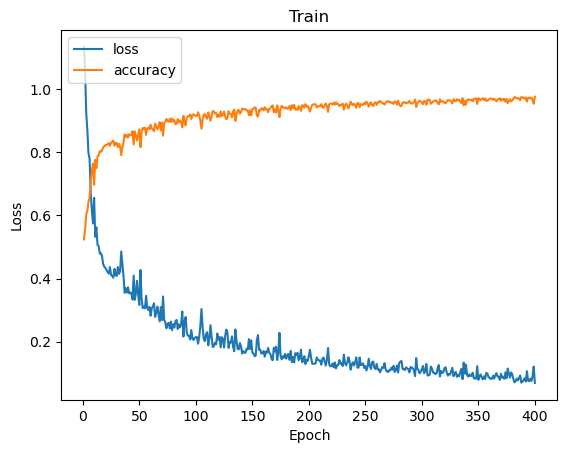

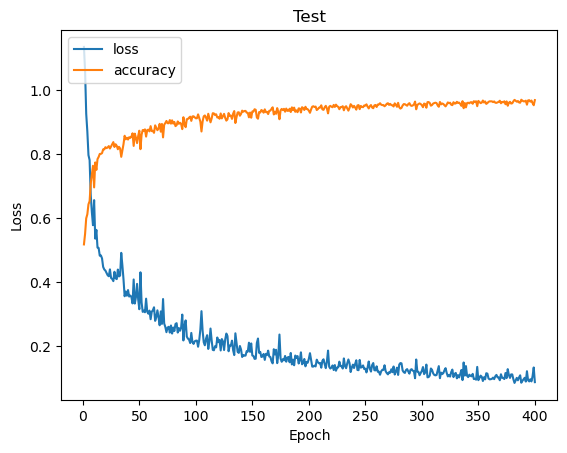

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])